In [65]:
import pennylane as qml
import torchvision
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import mlflow
mlflow.set_tracking_uri('http://127.0.0.1:5000')

In [66]:
image_size = 12
batch_size = 20
epochs = 20
selected_label = 0
n_samples = 200
n_qubits = 4
n_layers = 22
noise_gain = torch.pi/8
noise_offset = torch.pi/2
seed = 100

In [67]:
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(image_size), torchvision.transforms.ToTensor()]
    ))

/home/lc3267/Documents/CodeWorkspace/HIDA-Deep-Fake/.venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


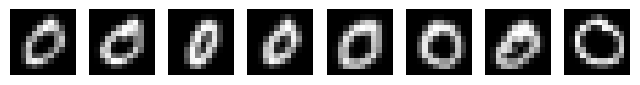

In [68]:
images = (dataset.train_labels==selected_label).nonzero().flatten()

n_figures = 8
plt.figure(figsize=(8, 8))
for i, zidx in enumerate(images[:n_figures]):
    image = dataset[zidx][0].reshape(image_size,image_size)
    plt.subplot(1,n_figures,i+1)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

In [69]:
def generate_grid(domain, samples):
    tensors = tuple(2 * [torch.linspace(domain[0], domain[1], steps=samples)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    return mgrid

In [70]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, n_samples):
        self.z = torch.stack([dataset[zidx][0][0] for zidx in images[:n_samples]]) # first [0] discards label, second [0] discards color channel
        self.x = torch.stack([generate_grid([-torch.pi/2, torch.pi/2], image_size) for _ in range(self.z.shape[0])])

    def __len__(self):
        return len(self.z)

    def __getitem__(self, idx):
        return self.z[idx], self.x[idx]

gan_dataset = Dataset(images, n_samples)
dataloader = torch.utils.data.DataLoader(gan_dataset, batch_size=batch_size, shuffle=True)

In [71]:
class Discriminator(nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [72]:
class NoiseSource(nn.Module):

    def __init__(self, output_shape, seed, noise_gain, noise_offset, **kwargs) -> None:
        super().__init__(**kwargs)

        self.rng = torch.Generator().manual_seed(seed)
        self.output_shape = output_shape
        self.noise_gain = noise_gain
        self.noise_offset = noise_offset

    def forward(self):
        return self.noise_offset + torch.randn(self.output_shape, generator=self.rng) * self.noise_gain

In [73]:
class Generator(nn.Module):
    
    def __init__(self, n_qubits, n_layers, **kwargs) -> None:
        super().__init__(**kwargs)

        self.n_qubits = n_qubits
        self.n_layers = n_layers + 1

        dev = qml.device("default.qubit", wires=self.n_qubits)
        self.qnode = qml.QNode(self.circuit, dev, interface="torch")
        self.qlayer = qml.qnn.TorchLayer(self.qnode, {"weights": [self.n_layers, self.n_qubits, self.vqc(None)]})


    def circuit(self, weights, inputs):
        x = inputs[:, :2]   # [B*IS*IS, NQ+2] -> [B*IS*IS, 2]
        p = inputs[:, 2:]   # [B*IS*IS, NQ+2] -> [B*IS*IS, NQ]
        
        self.nec(p) # prepare random states

        # build the trainable circuit
        for layer in range(self.n_layers-1):
            self.vqc(weights[layer])
            self.iec(x)

        # add a last vqc layer
        self.vqc(weights[-1])

        return qml.expval(qml.PauliZ(0))

    def nec(self, p):
        for qubit in range(self.n_qubits):
            qml.RY(p[:, qubit], wires=qubit)

    def iec(self, x):
        for qubit in range(self.n_qubits):
            qml.RY(x[:, 0], wires=qubit)
            qml.RX(x[:, 1], wires=qubit)

    def vqc(self, weights):

        if weights is None:
            return 3
        for qubit, qubit_weights in enumerate(weights):
            qml.RX(qubit_weights[0], wires=qubit)
            qml.RZ(qubit_weights[1], wires=qubit)

        for qubit, qubit_weights in enumerate(weights):
            qml.CRX(
                qubit_weights[2],
                wires=[
                    weights.shape[0] - qubit - 1,
                    (weights.shape[0] - qubit) % weights.shape[0],
                ],
            )

    def forward(self, p, x):
        # get the known variables
        batch_size = x.shape[0]
        image_sidelength = x.shape[1]
        
        x_in = x.reshape(batch_size, -1, 2) # [B, IS, IS, 2] -> [B, IS*IS, 2]
        p_in = p.repeat(batch_size* image_sidelength * image_sidelength)   # [NQ] -> [B*IS*IS*NQ]
        p_in = p_in.reshape(batch_size,image_sidelength*image_sidelength, self.n_qubits) # [B*IS*IS*NQ] -> [B, IS*IS, NQ]
        combined = torch.cat((x_in, p_in), dim=2) # [B, IS*IS, 2] + [B, IS*IS, NQ] -> [B, IS*IS, NQ+2]
        z = self.qlayer(combined)
        z = (z +1) /2 # move into range [0,1]
        return z

In [74]:
noise_source = NoiseSource((n_qubits), seed=seed, noise_gain=noise_gain, noise_offset=noise_offset)
generator = Generator(n_qubits=n_qubits, n_layers=n_layers)
discriminator = Discriminator()

In [75]:
opt_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.01)
opt_generator = torch.optim.Adam(generator.parameters(), lr=0.1)

loss = nn.BCELoss()

In [76]:
torch.autograd.set_detect_anomaly(True)
mlflow.set_experiment('QGAN Test')
with mlflow.start_run() as run:
    mlflow.log_param("image_size", image_size)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("selected_label", selected_label)
    mlflow.log_param("n_samples", n_samples)
    mlflow.log_param("n_qubits", n_qubits)
    mlflow.log_param("n_layers", n_layers)
    mlflow.log_param("noise_gain", noise_gain)
    mlflow.log_param("noise_offset", noise_offset)
    mlflow.log_param("seed", seed)

    print(f"Training started. Navigate to the MLflow UI at http://localhost:5000/#/experiments/{run.info.experiment_id}/runs/{run.info.run_id}")

    # Sample all the noise beforehand so have the same each epoch
    all_p_hat = []
    for i, (z, x) in enumerate(dataloader):
        all_p_hat.append(noise_source())
    all_p_hat = torch.stack(all_p_hat)

    for epoch in range(epochs):

        for i, (z, x) in enumerate(dataloader):

            z_hat = generator(all_p_hat[i], x)

            y_hat = discriminator(z_hat.detach())
            y = discriminator(z.view(-1, image_size * image_size))

            disc_loss_real = loss(y, torch.ones_like(y))
            disc_loss_fake = loss(y_hat, torch.zeros_like(y_hat))

            opt_discriminator.zero_grad()
            disc_loss_real.backward()
            disc_loss_fake.backward()
            opt_discriminator.step()

            opt_generator.zero_grad()
            y_hat = discriminator(z_hat)
            gen_loss_fake = loss(y_hat, torch.ones_like(y_hat))
            gen_loss_fake.backward()
            opt_generator.step()

            mlflow.log_metric("discriminator_loss", disc_loss_real.item() + disc_loss_fake.item())
            mlflow.log_metric("generator_loss", gen_loss_fake.item())

        preds = z_hat.reshape(-1, image_size, image_size).detach().cpu().numpy()
        for i in range(min(n_figures, batch_size)):
            mlflow.log_image(preds[i], f"generated_image_{i}_epoch_{epoch}.png")


Training started. Navigate to the MLflow UI at http://localhost:5000/#/experiments/251055496897115745/runs/491d4fe6adb1418ab255ae18c5f62cad
